<center>
 <h1> INF395 - Introducción a las Redes Neuronales Artificiales</h1>
    <h2> Tarea 1</h2>
</center>
<b>Integrantes:</b>
* Camilo Saldías González - 201223512-K - camilo.saldias.12@sansano.usm.cl
* Felipe Vásquez Astudillo - 201473504-9 - felipe.vasquez.14@sansano.usm.cl

# Tabla de contenido
* [2.-*Deep Networks*](#p2)
* [3.-Convolutional Neural Network (CNN) en CIFAR](#p3)

<div id='p2' />
## 2. Deep Networks

In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import backend as K
from keras import losses as L
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullFormatter
from timeit import default_timer as timer
import tensorflow as tf

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)

a)

El proceso de escalar es el mismo que se sugiere en la pregunta 1, ítem a) por lo que solo basta con repetir este proceso para el conjunto de testeo.

In [3]:
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = X_train_scaled.pop('MEDV').values.reshape(-1,1)
scaler = StandardScaler().fit(df_test)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = X_test_scaled.pop('MEDV').values.reshape(-1,1)

b)

Dado que se pedirá la creación de modelos muy parecidos entre sí, se definen funciones para repetir estas tareas.

In [4]:
def genModelo(capas,inicializador,activacion):
    model = Sequential()
    for i in range(capas):
        model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer=inicializador,activation=activacion))
    model.add(Dense(1, kernel_initializer=inicializador,activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return(model)

In [5]:
def evaluarGrad(modelo):
    ###calculate gradients
    loss = L.mean_squared_error(model.output,y_train)
    listOfVariableTensors = model.trainable_weights
    #We can now calculate the gradients.
    gradients = K.gradients(loss, listOfVariableTensors)
    sess = K.get_session()
    evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
    evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
    return(evaluated_gradients)

In [6]:
def genHistogramas(capas,casillas,gradientes):
    nr=10
    while(nr*2>capas):
        nr-=1
    fig, axes = plt.subplots(nrows=nr, ncols=2,figsize=(15,5*nr))
    ax = axes.flatten()
    j=1
    for i in range(2*capas):
        if(i%2==0):
            titulo="Velocidad de pérdida pesos capa "+str(j)+"-"+str(j+1)
        else:
            j+=1
            continue
        if(len(gradientes[i].shape)!=1):
            temp=np.concatenate(gradientes[i])
        else:
            temp=gradientes[i]
        ax[j-1].set_title(titulo)
        ax[j-1].hist(temp.tolist(),bins=casillas)
    plt.tight_layout()
    plt.show()

In [7]:
def resumenGrafico(history):
    if ('acc' in history.history):
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
        ax = axes.flatten()
        ax[0].plot(history.history['loss'])
        ax[0].plot(history.history['val_loss'])
        ax[0].set_title('Perdida del modelo')
        ax[0].set_ylabel('Perdida')
        ax[0].set_xlabel('Epoch')
        ax[0].legend(['Train', 'Val'], loc='upper left')
        ax[1].plot(history.history['acc'])
        ax[1].plot(history.history['val_acc'])
        ax[1].set_title('Precision del modelo')
        ax[1].set_ylabel('Precision')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['Train', 'Val'], loc='upper left')
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Perdida del modelo')
        plt.ylabel('Perdida')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
    plt.show()

La idea de calcular la gradiente de la función de pérdida en cada peso es determinar la velocidad con que cambia el error en cada peso y hacer cambios acordes.

Por lo anterior, con gradiente descendiente se busca que la velocidad sea negativa para que así el error disminuya con cada iteración.

Se procede a generar el modelo con una capa de 200 unidades, inicialización uniforme y función de activación sigmoide. Luego generamos los gráficos pedidos, de manera de poder observar la distribución del error antes de entrenar el modelo.

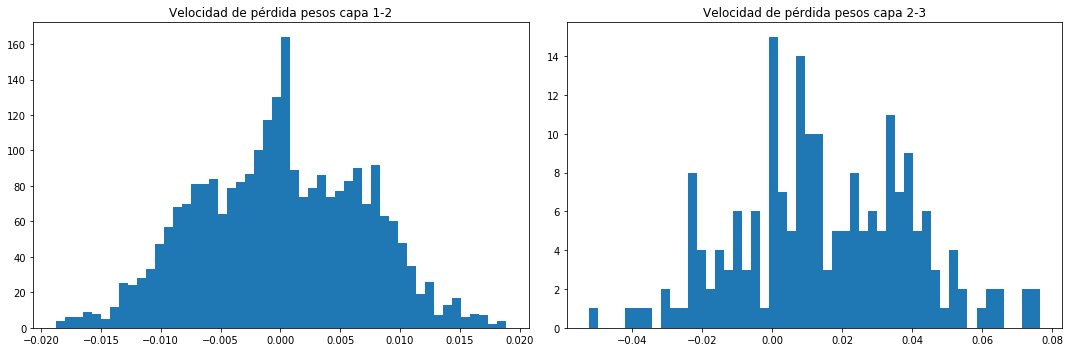

In [258]:
model=genModelo(1,'uniform','sigmoid')
gradientes=evaluarGrad(model)
genHistogramas(2,50,gradientes)

La distribución mostrada inicialmente se asemeja a una de distribución normal, explicado parcialmente por la naturaleza de la inicialización. Velocidad de pérdida distribuida hacia ambos lados es natural, pues es esperable que cada peso inicializado uniformemente sea modificado en direcciones distintas (dependiendo de la evaluación de sus gradientes individuales).

Posteriormente se entrena el modelo con 300 epochs y se repite el proceso de cálculo de gradientes y visualización.

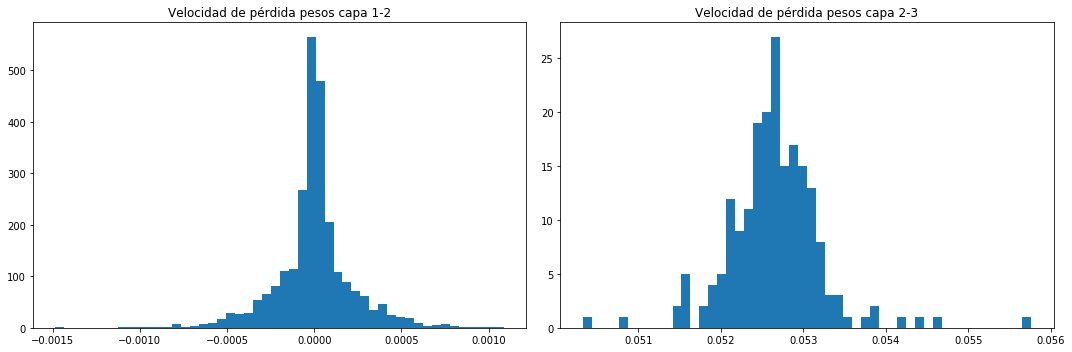

In [259]:
history=model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
gradientes=evaluarGrad(model)
genHistogramas(2,50,gradientes)

Como se puede observar, tras el entrenamiento la distribución del error de los pesos disminuye en magnitud, centrándose notablemente alrededor del 0 en el primer histograma, mientras que el segundo muestra un centro variable. Recompilación del código muestra que la velocidad del error se distribuye similarmente a una distribución normal.

Esta distribución es una representación de como están cambiando el conjunto de pesos en ese instante (epoch), lo que significa que si centra en el 0, la gran mayoría de los pesos no sufrirán cambios, y si la magnitud de las velocidades es muy pequeña, entonces se espera que no hayan cambios sustanciales hacia epochs subsiguientes para los pesos que sí van a cambiar.

Notar que en este caso, la gradiente es mucho menor en las primeras capas que antes del entrenamiento. Este fenómeno es el conocido como __gradiente desvaneciente__ pues las gradientes son tan pequeñas que impiden más cambios en la red, independiente de cuanto más sean entrenadas.

Por otro lado, los pesos entre la capa 2 y 3 sufrirán más cambios a lo largo de cada epoch y serán (en esta red shallow) el origen de la fluctuación de la pérdida al variar su centro (algunos pasos aumentarán la pérdida y otros los disminuirán) lo cuál a su vez podría explicar la variabilidad del centro de la distribución del segundo histograma.

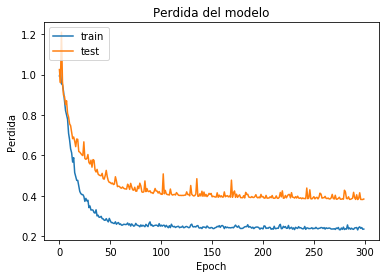

In [260]:
resumenGrafico(history)

En efecto, la red se satura posterior al entrenamiento. El hecho de que se sature se explica por el bajo aprendizaje de la primera capa (como se observa en el primer histograma) por lo que no se aprende más de la entrada y los cambios posteriores pueden a lo más mantener la red a un nivel constante.

c)

Se genera el modelo del enunciado, uno que utiliza 5 capas escondidas.

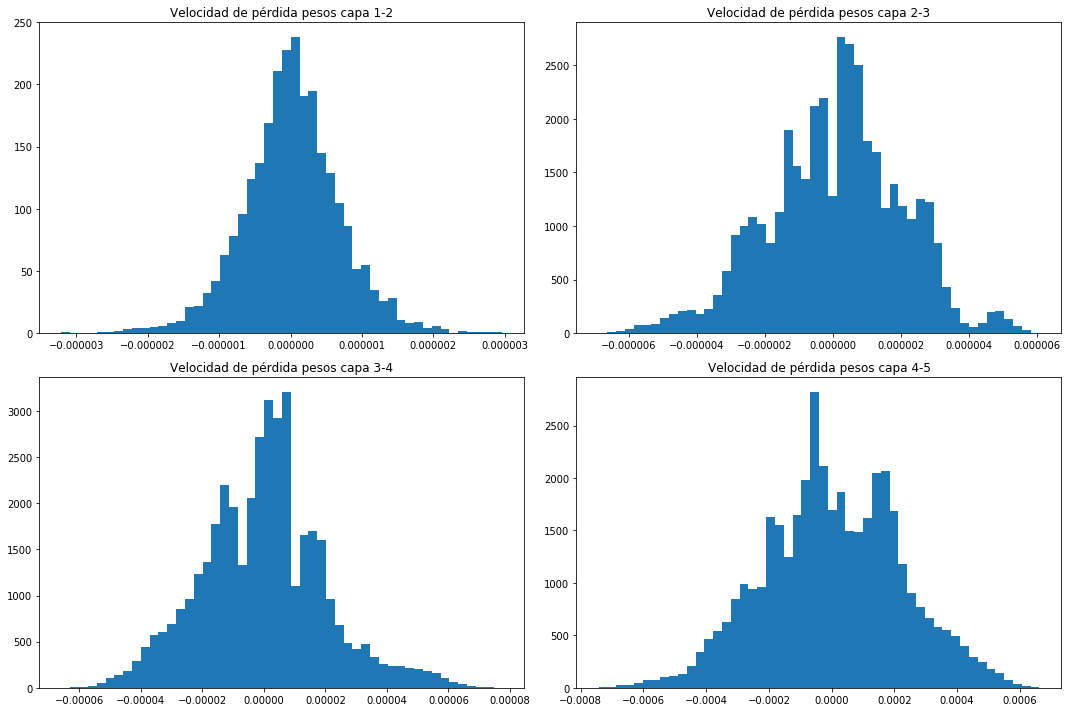

In [216]:
model=genModelo(5,'uniform','sigmoid')
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

En este caso todos los gráficos muestran centro en 0 y una velocidad de pérdida muy pequeña, por lo que el problema de gradiente desvaneciente sucede antes de empezar el entrenamiento. Por esto, es esperable que el modelo no logre mejorar ni empeorar su desempeño a lo largo del tiempo.

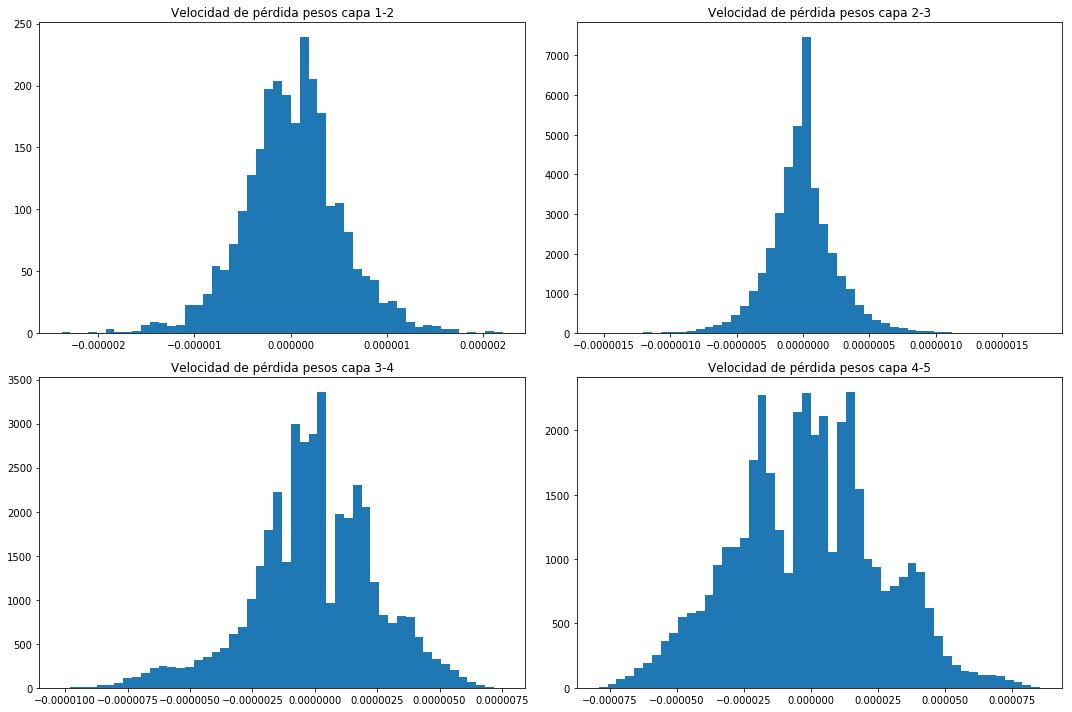

In [217]:
history=model.fit(X_train_scaled.as_matrix(), y_train, epochs=500,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

El problema se mantiene, por lo que la red ha mantenido su saturación. El origen del problema de la gradiente desvaneciente es que se tiende a perder efecto cuando la gradiente es propagada, por lo que las primeras capas tienden a tener un aprendizaje muy pequeño.

Que el aprendizaje sea mínimo en las primeras capas es un problema, después de todo esta es la capa de entrada y es donde más debería aprenderse.

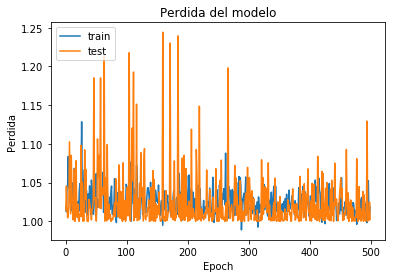

In [218]:
resumenGrafico(history)

Efectivamente, el modelo no ha logrado mejorar su desempeño desde el inicio de su entrenamiento.

d)

Intuitivamente, dado que estamos hablando de una inicialización, se debería de amortiguar el problema de gradiente desvaneciente antes del entrenamiento.

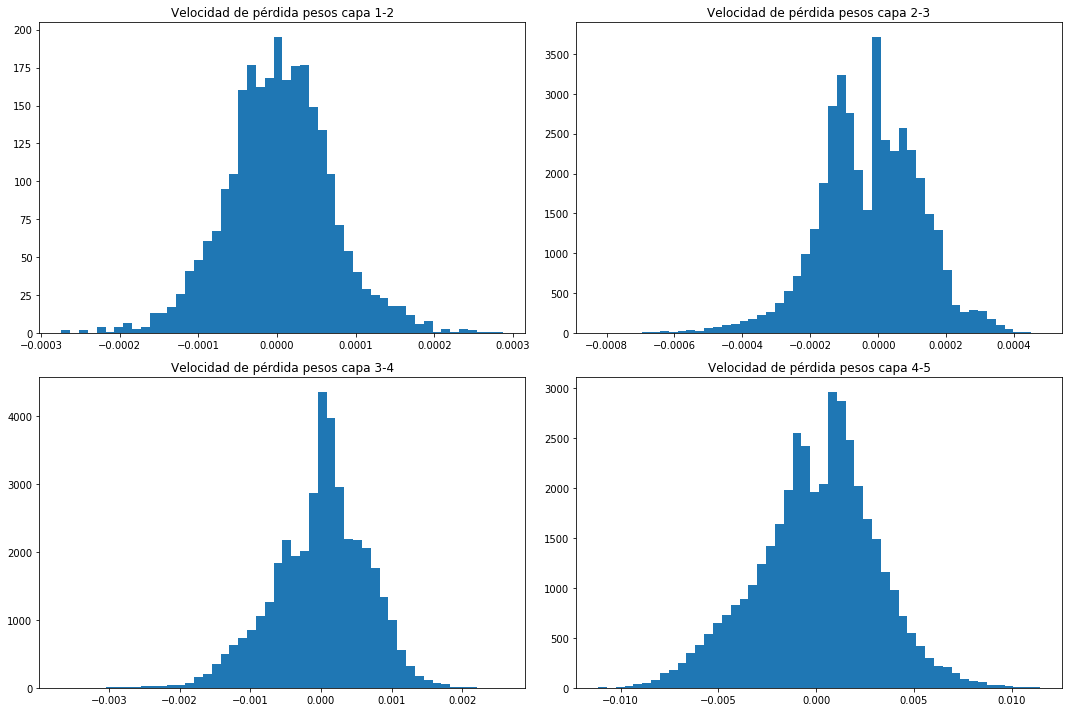

In [204]:
model=genModelo(5,'glorot_uniform','sigmoid')
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

Dado que la magnitud del aprendizaje observado en la primera capa es relativamente parecido al resto de las capas, se puede afirmar que se amortigua, pero con dudoso efecto precisamente porque todos las gradientes evaluadas parecen tener magnitudes parecidas y están centradas en 0.

Se estima entonces que existirá mayor fluctuación en el gráfico de pérdida, sin embargo es muy posible de quede todas formas se sature durante el entrenamiento.

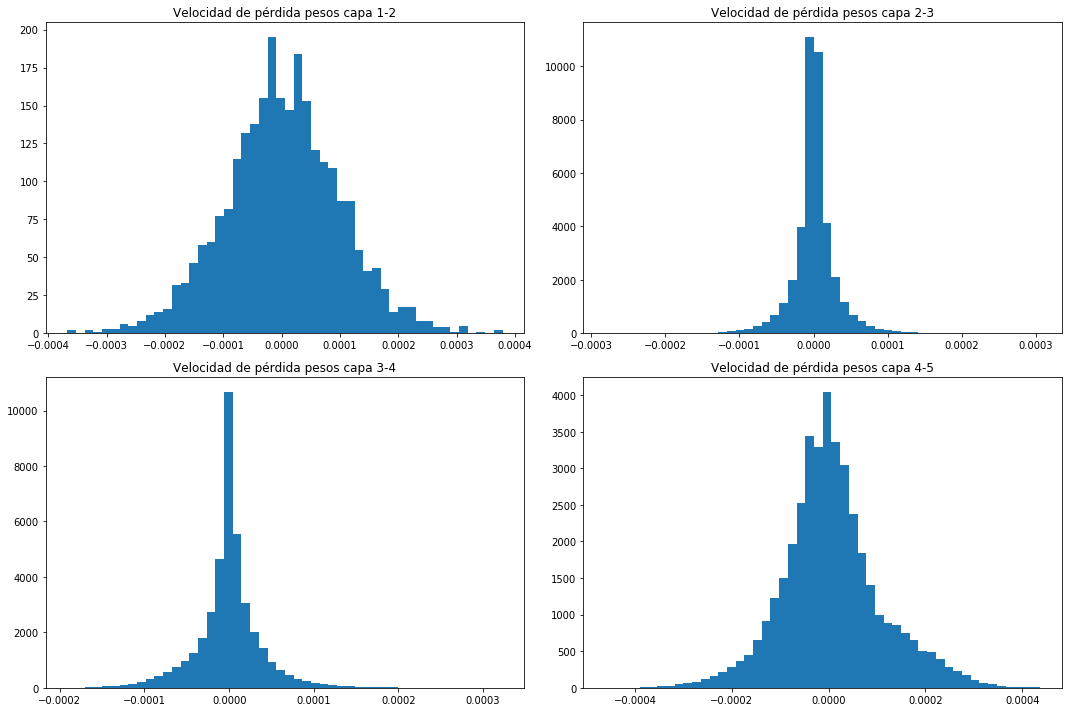

In [205]:
history=model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

En base a los histogramas, debido a la forma que tienen se puede afirmar de que la fluctuación del error continúa.

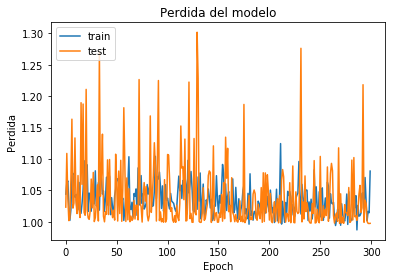

In [206]:
resumenGrafico(history)

En efecto el aprendizaje es alto, la red es sensible al cambio sin embargo sigue saturada por lo que el problema sigue presente. Esto significa que la raíz del problema podría no corresponder a uno de inicialización.

e)

Se genera el modelo utilizando función de activación ReLU.

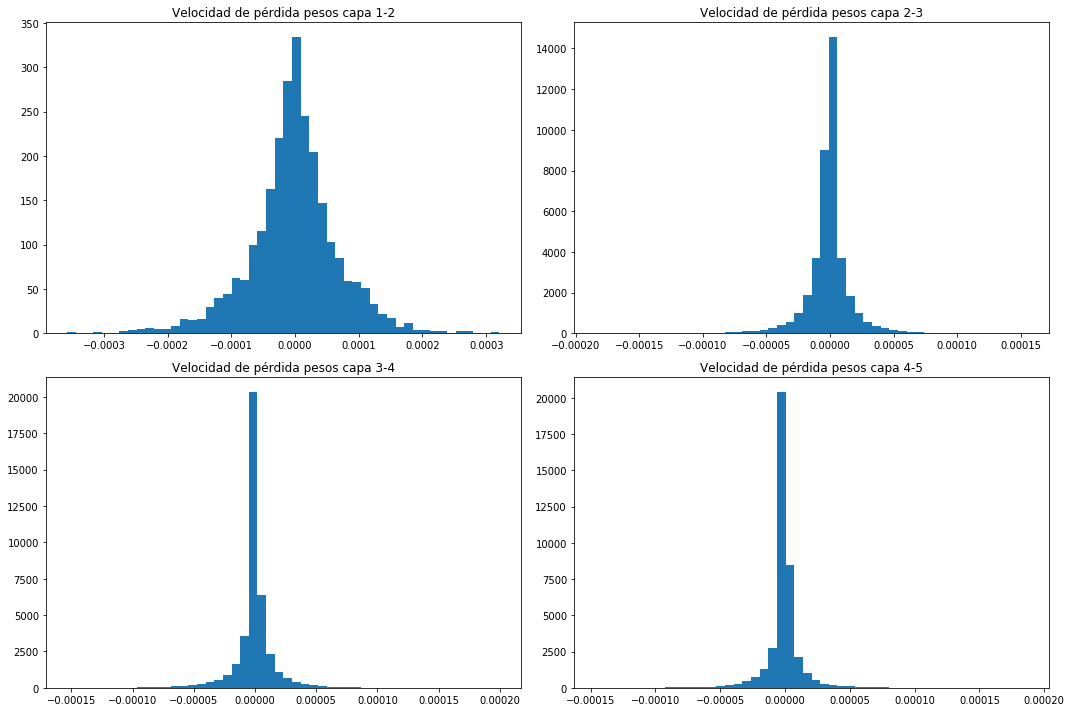

In [207]:
model=genModelo(5,'uniform','relu')
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

En base a la distribución de la velocidad de errores, la primera capa es mucho más propensa a cambios que todas las demás capas, por lo tanto se espera que se produzca un aprendizaje mejor que el de los casos anteriores.

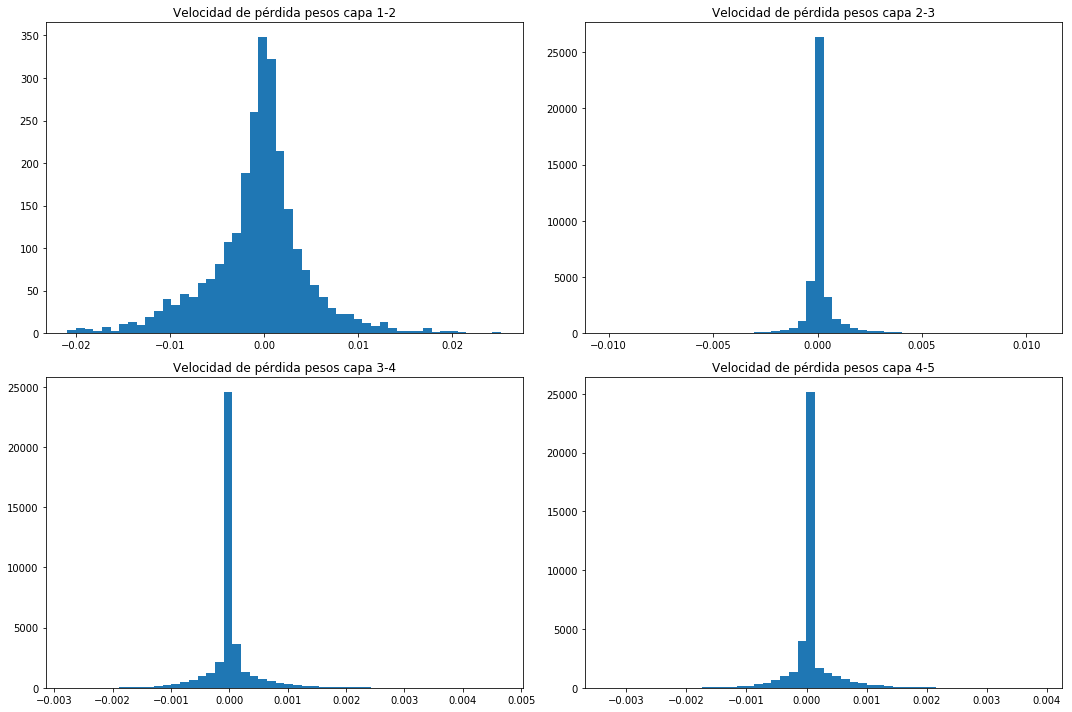

In [208]:
history=model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

La distribución esta vez es más delgada entre la capa 1 y 2, pero aún así sigue siendo mayor que la del resto de las capas lo que significa que el nivel de aprendizaje en la entrada es menor pero sigue presente. Esto significa menor fluctuacioń en el aprendizaje.

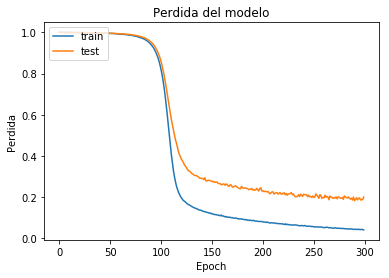

In [209]:
resumenGrafico(history)

Como se puede observar, el problema de gradiente desvaneciente ha sido amortiguado en gran medida al menos para los primeros 100 epochs, convergiendo a un valor razonable de pérdida (respecto al resto de los modelos al menos).

Se procede a utilizar la inicialización *he uniforme*.

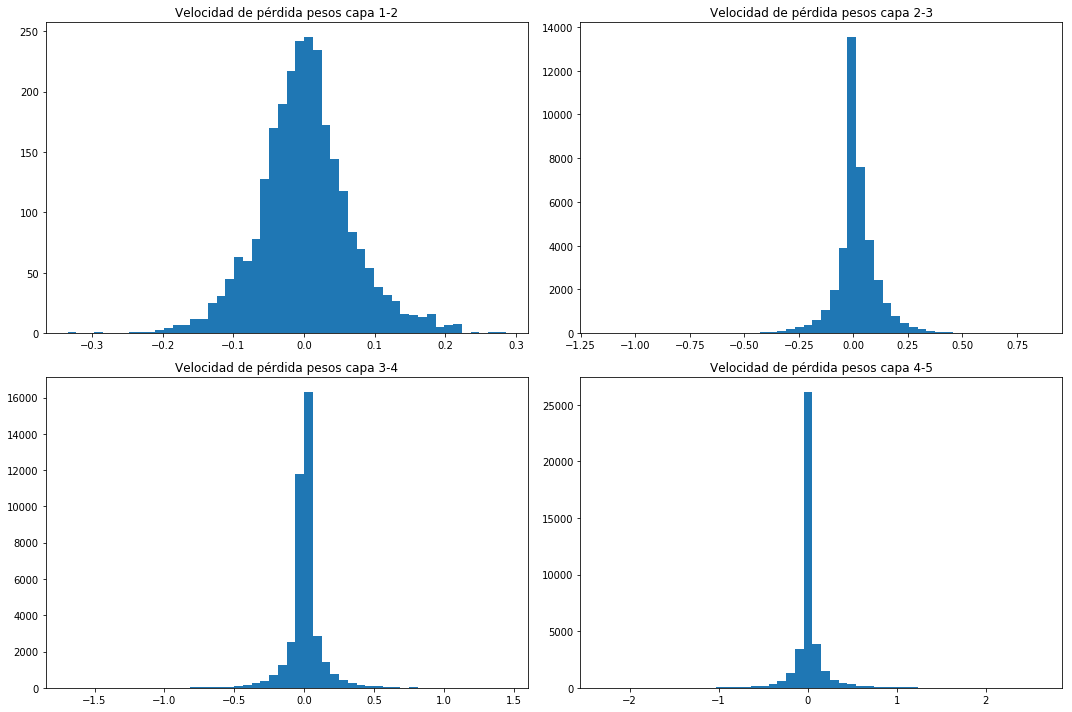

In [8]:
model=genModelo(5,'he_uniform','relu')
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

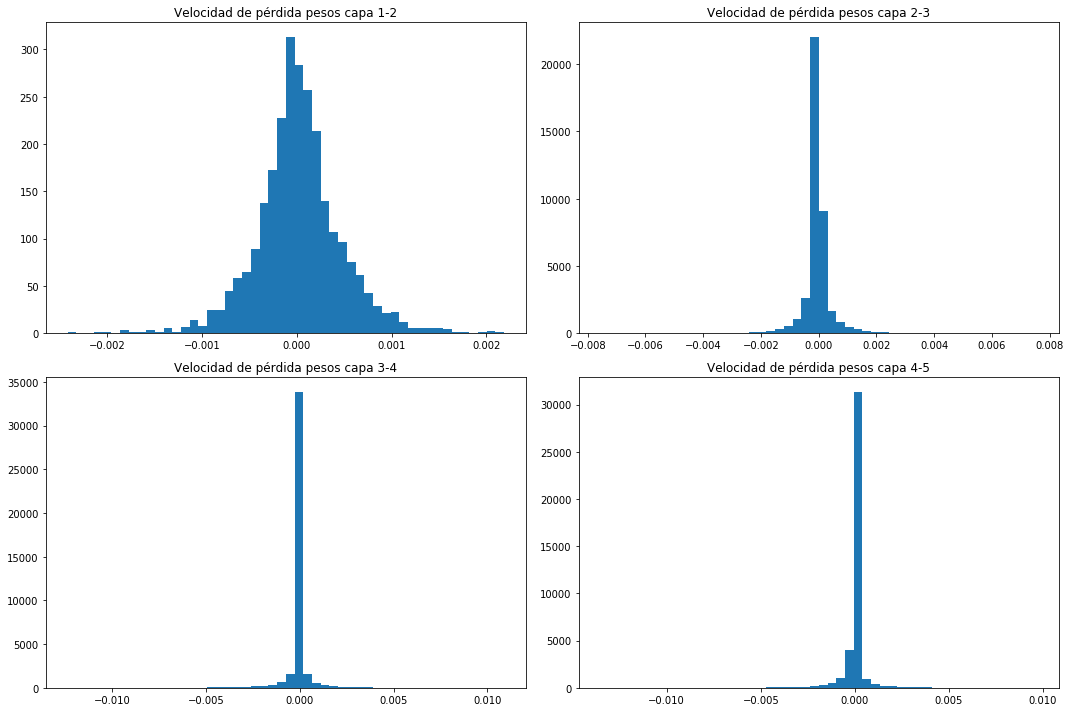

In [9]:
history=model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

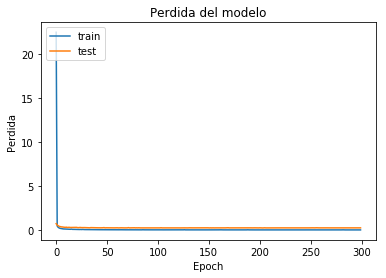

In [10]:
resumenGrafico(history)

El grafico muestra una gran rapidez de aprendizaje, sin embargo notar de que la pérdida del primer epoch es mucho mayor a la del resto de los epochs por lo que se pierde la visualización correcta. También se puede observar overfitting pero es difícil decir que tanto se produce.

Ignorando el primer epoch, se puede hacer una mejor visualización de la pérdida.

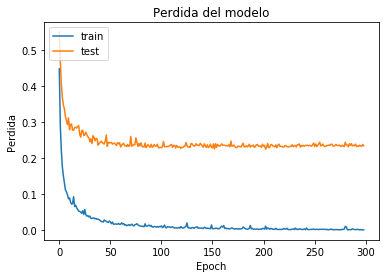

In [11]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Perdida del modelo')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Se puede observar de que la pérdida del conjunto de validación es aproximadamente parecido al del modelo anterior, lo que nos lleva a la conclusión de que esta distribución acelera el aprendizaje del modelo en comparación a ReLU, cuyo aprendizaje sucede alrededor del epoch 100.

De todo lo anterior se puede afirmar de que utilizar ReLU combate efectivamente el problema de gradiente desvaneciente. Se puede atribuir esta eficiencia al modo en que se representa la derivada de esta función.

$$
f'(x) = \left\{
        \begin{array}{ll}
            1 & \quad x > 0 \\
            0 & \quad \text{si no}
        \end{array}
    \right.
$$

Con una derivada que funciona en términos de enteros, se mitiga la complicación de que números muy pequeños esten siendo multiplicados.

Además, se hace bastante evidente que la inicialización de los pesos tiene un impacto en la velocidad de convergencia. Empíricamente es cosa de ver la comparación entre los gráficos finales de ambos modelos, utilizando la inicialización he uniforme se lograron resultados muy precisos.

e2)

Utilizando inicialización uniforme y ReLU fue posible encontrar convergencia, aproximadamente tras 120 epochs.

Se procede probando la inicialización de glorot uniforme con función de activación ReLU.

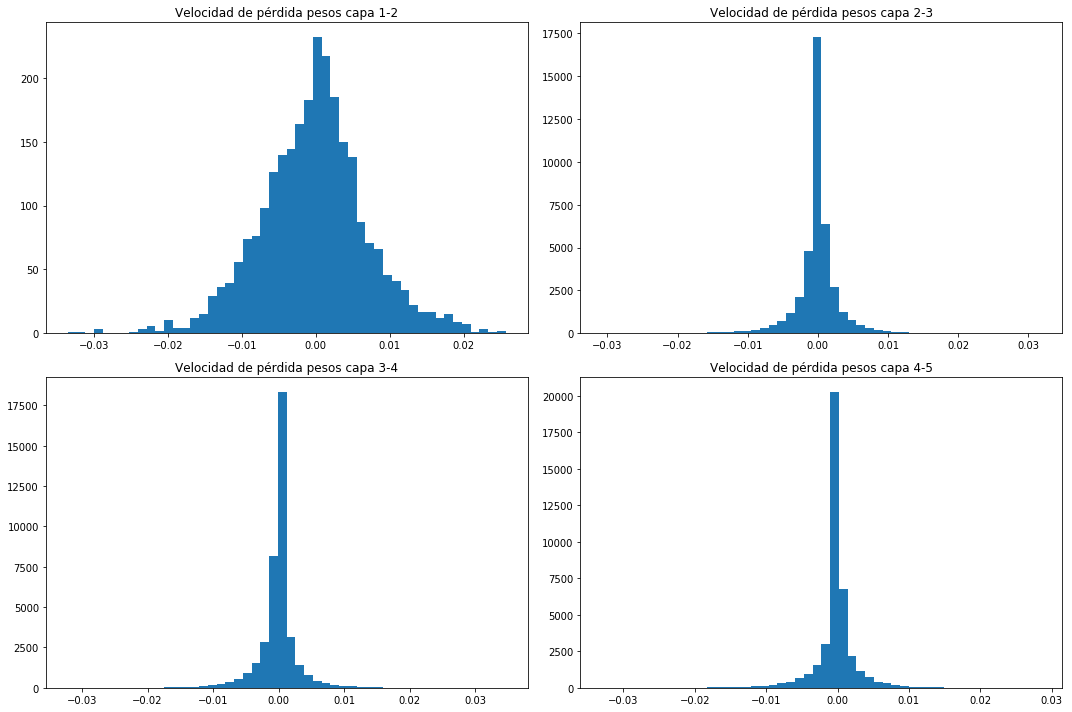

In [213]:
model=genModelo(5,'glorot_uniform','relu')
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

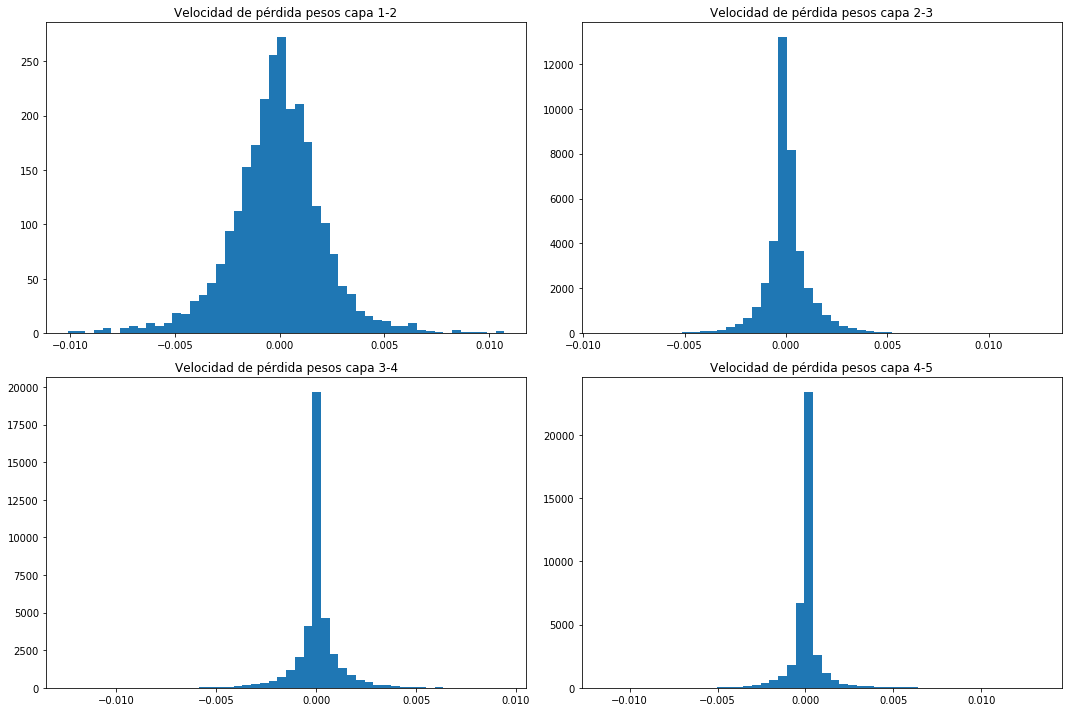

In [214]:
history=model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
gradientes=evaluarGrad(model)
genHistogramas(4,50,gradientes)

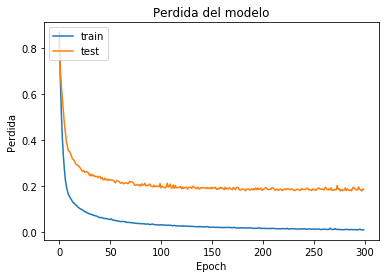

In [215]:
resumenGrafico(history)

La convergencia de este modelo es mucho más parecido a la entregada por la red _shallow_ del ítem b), teniendo una pérdida menor que el primer modelo.

f)

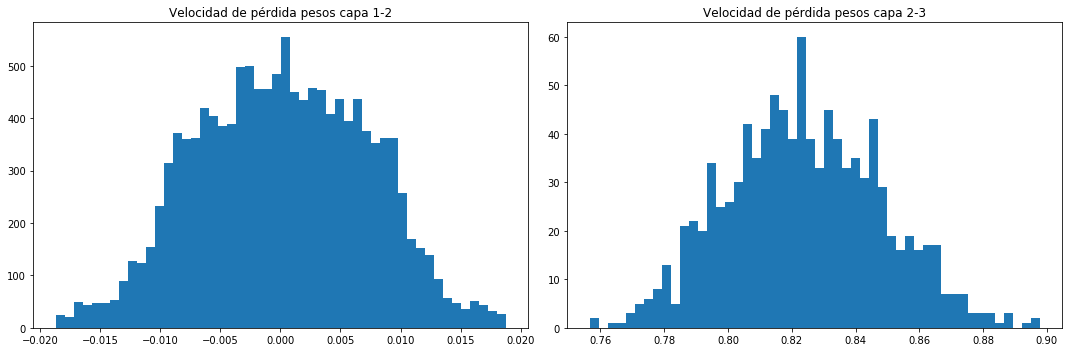

In [230]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.003)
model.compile(optimizer=sgd,loss='mean_squared_error')
gradientes=evaluarGrad(model)
genHistogramas(2,50,gradientes)

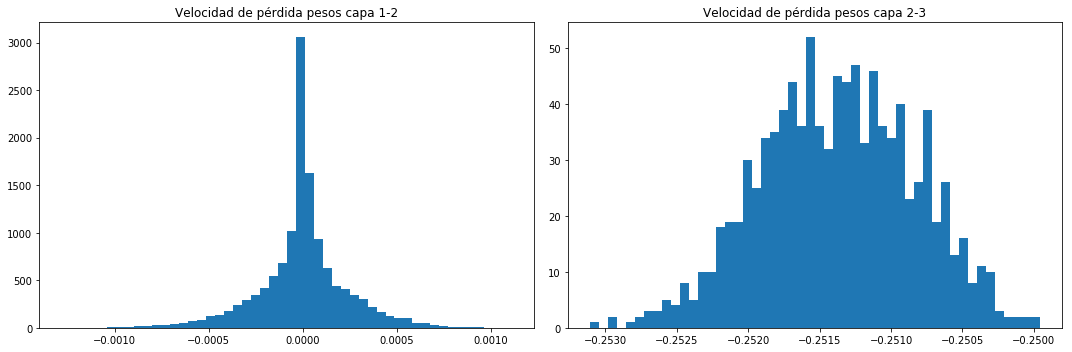

In [231]:
history=model.fit(X_train_scaled.as_matrix(), y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
gradientes=evaluarGrad(model)
genHistogramas(2,50,gradientes)

El agregar más unidades a la capa oculta parece haber potenciado el aprendizaje entre la capa escondida y la de salida antes del entrenamiento por lo que el problema de la gradiente desvaneciente aparece desde antes.

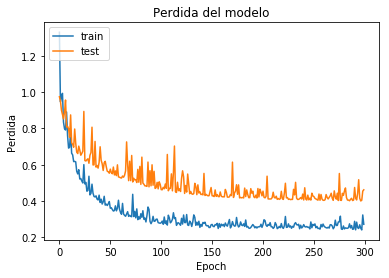

In [233]:
resumenGrafico(history)

Con una segunda capa de pesos así de sensible, es esperable que pueda observarse este tipo de fluctuaciones. El modelo logra converger a un valor pero variando con mayor magnitud que en el modelo del ítem b). 

Este comportamiento se reduce a que debido a la primera capa de pesos eventualmente deja de aprender de la entrada (visible en el segundo histograma), se llega a un valor en que se centraliza la pérdida. Sin embargo los pesos entre la capa escondida y de salida siguen sensibles, con valores bastante altos en comparación por lo que con cada epoch se hacen cambios fuertes en estos pesos y luego se corrigen utilizando la información de la gradiente.

A grandes rasgos, más unidades en una red neuronal shallow solo genera una variación más fuerte del modelo y no soluciona la eventual saturación que fue observada en el modelo del ítem b).

<div id='p3' />
## 3. Convolutional Neural Network (CNN) en CIFAR

Parte a)

Primero implementamos la función entregada por el enunciado. Solamente se cambió el encoding de la descompresión de las imágenes, pues el resto de la función se comporta correctamente.

In [3]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        Y = np.array(Y)
        return X, Y
def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    #add your Xval
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

Los conjuntos de entrenamiento y prueba son guardados.

In [4]:
x_train,y_train,x_test,y_test=load_CIFAR10('/home/difroggy/Documents/Redes Neuronales/data')

El código a continuación se provee en caso de que no se posea previamente los datos de entrenamiento/testeo.

In [8]:
#from keras.datasets import cifar10
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Parte b)

El enunciado indica que existen 10 clases distintas enumeradas del 0 al 9, por lo tanto se define eso en la variable *num_classes*.

In [5]:
import keras
num_classes=10
x_train = x_train.reshape((x_train.shape[0],3,32,32))
x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],3,32,32))
x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Notar que la transformación representa a $50,000$ imágenes de $32 \times 32$ con $3$ canales distintos (RGB).

In [6]:
x_train.shape

(50000, 32, 32, 3)

Luego, los datos de entrada son normalizados. Dado que $Y_{tr}$ e $Y_t$ son vectores de 1, no es necesario normalizarlos.

In [7]:
x_train=x_train/255
x_test=x_test/255

El conjunto de validación $X_v$ y $Y_v$ es no es guardado en variables por ahora, si no que se genera implícitamente con el argumento *validation_split* de la función entrenadora _fit()_. Este argumento define el porcentaje del conjunto de entrenamiento que se utilizará como validación, y como se piden 5,000 imágenes de un conjunto de 50,000, se manejará el 10%.

Parte c)

Se crea el modelo pedido, con sus respectivas capas de convolución, subsampling, una capa feedforward de 512 unidades y una final de 10 (correspondiente a cada categoría).

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [206]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

A continuación se hará una breve explicación de como se calculan las dimensiones y los parámetros de la primera capa convolucional.

**Cambio de dimensionalidad**

En la primera capa convolucional, se tiene una imagen de $32\times32$ de entrada con $3$ canales o _feature maps_ distintos. El primer argumento de la función _Conv2D()_ especifica la dimensionalidad de la salida por lo que estamos hablando de una salida de 64 _feature maps_. Como se mantiene la dimensión de la imagen, tenemos la siguiente transformación desde entrada y salida.

$$32\times32\times3\rightarrow32\times32\times64$$

**Número de parámetros**

Un feature map es construido a partir de un filtro de $3\times3$ para cada uno de los $3$ canales RGB de la imagen original. Además se considera que cada feature map posee un bias, por lo tanto el número de parámetros es el siguiente.

$$(3\times3\times3+1)\times64=1792$$

Vale mencionar que la función _.summary()_ muestra el número de parámetros y la dimensionalidad de cada output, por lo que usaremos eso a modo de comparación.

In [207]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_47 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_48 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4096)              0         
__________

Cada pool es un subconjunto de la imagen inicial. Con filtros de $2\times2$ y strides predeterminados de 2, sencillamente corta a la mitad las dimensiones de la imagen manteniendo los feature maps. Notar que no hace ningún aprendizaje, solo disminuye dimensiones por lo que no hace cambios en el número de parámetros.

Finalmente se muestra un esquema ilustrativo de lo recién explicado.

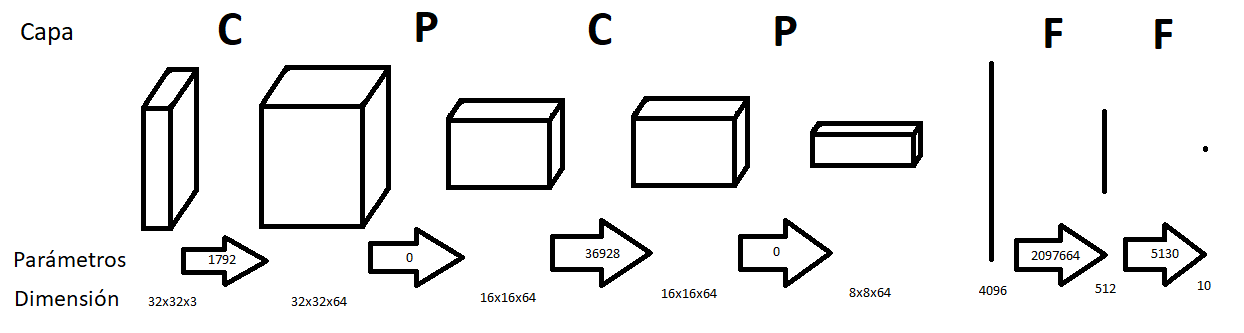

In [122]:
from IPython.display import Image
Image("esquema.png")

Parte d)

Para el entrenamiento de los modelos, se utilizarán batches de 128 samples.

In [17]:
batch_size=128

En la implementación del enunciado, se menciona que se quiere disminuir el learning rate en 2 cada 10 epochs, sin embargo se presenta un código que lo divide cada 5 por lo que se aprovechará la instancia para comparar ambos acercamientos.

Empezamos con cada 5 epochs.

In [13]:
epochs=25
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math

In [273]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,loss='mean_squared_error',metrics=['acc'])
history=model.fit(x_train, y_train,epochs=epochs, batch_size=batch_size,
                  validation_split=0.1, shuffle=True, callbacks=[lrate],verbose=0)

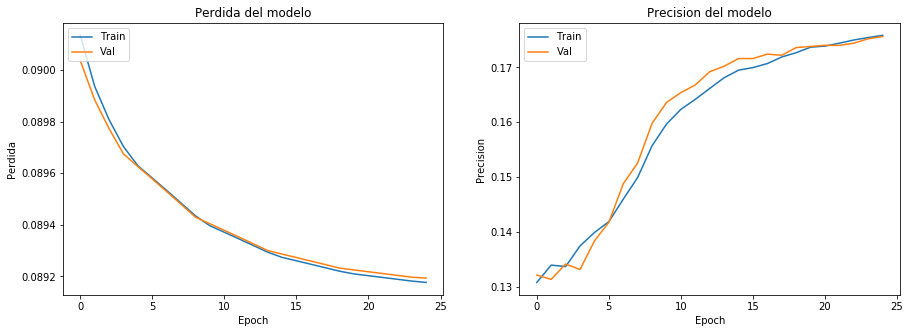

In [274]:
resumenGrafico(history)

Los resultados son bastante alentadores en el sentido de que no se produce overfitting, el error del conjunto de validación difiere poco con la del conjunto de entrenamiento.

Luego se utiliza la segunda implementación, la sugerida por el enunciado cada 10 epochs.

In [275]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [276]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/10))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,loss='mean_squared_error',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size,
                  validation_split=0.1, shuffle=True, callbacks=[lrate],verbose=0)
score = model.evaluate(x_test, y_test, verbose=0)

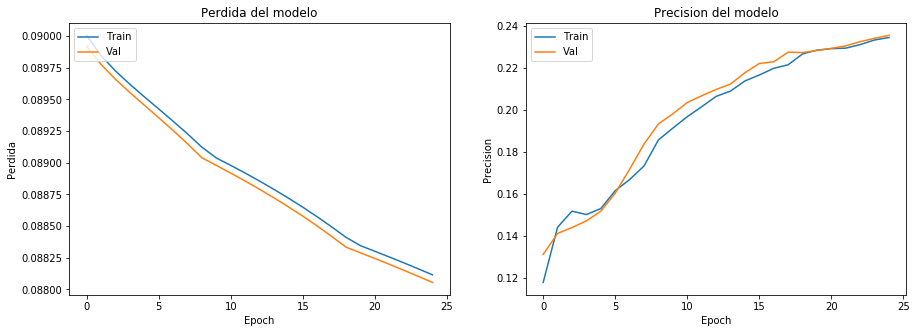

In [277]:
resumenGrafico(history)

El modelo sigue un comportamiento similar, con una ligera presencia de mayor error en la validación.

Como acotación, este set de datos tiene facilidad de producir overffiting (lo que se evidenciará en preguntas posteriores), por lo que la disminución del learning rate a lo largo de los epochs evade este problema. Sin embargo, con un learning rate así de pequeño, el aprendizaje del modelo es lento, lo cuál se puede apreciar en la magnitud del gráfico de precisión, el valor máximo siendo un 23% aproximadamente.

Se debiese esperar que mientras más epochs, el modelo mejore, sin embargo tomará un buen tiempo debido a la disminución del learning rate.

Parte e)

Se genera el modelo solicitado.

In [96]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',strides=(2,2), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same',strides=(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

__Cross-entropy__ es una función de pérdida utilizada en modelos de clasificación con output 0 a 1, indicando la probabilidad de que el elemento corresponda a la clasificación. En esta, la pérdida es mayor mientras más diverga el valor predicho del real. __Categorical cross-entropy__ es una variación de múltiples etiquetas, en que se calcula la pérdida individual de cada etiqueta y luego se suma.

Con 25 epochs, se entrena el modelo utilizando el código entregado por el enunciado y se probará utilizando la función de error _categorical cross-entropy_. 

In [97]:
epochs=25

In [98]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)
score = model.evaluate(x_test, y_test, verbose=0)

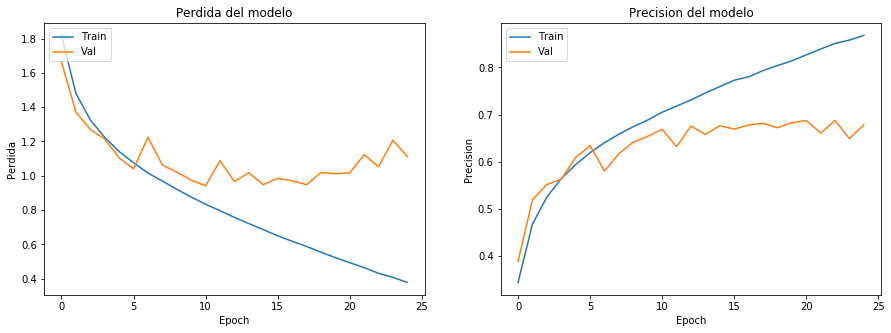

In [99]:
resumenGrafico(history)

Como se puede apreciar, el error de la validación es bastante mayor al de entrenamiento, lo que significa que se produce _overfitting_, desde aproximadamente la mitad de los epochs. A pesar de esto, la velocidad de aprendizaje utilizando esta función de error rápido, alcanzando el 80% aproximadamente a los 5 epochs.

Parte f)

En primera instancia haremos variación del tamaño del filtro. Primero declaramos una lista vacía para guardar los scores finales de cada entrenamiento.

In [33]:
scores=[]

Se definen los 15 epochs para el entrenamiento.

In [34]:
epochs=15

In [35]:
nc = 3
model = Sequential()
model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [36]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [37]:
scores.append(model.evaluate(x_test,y_test,verbose=0))

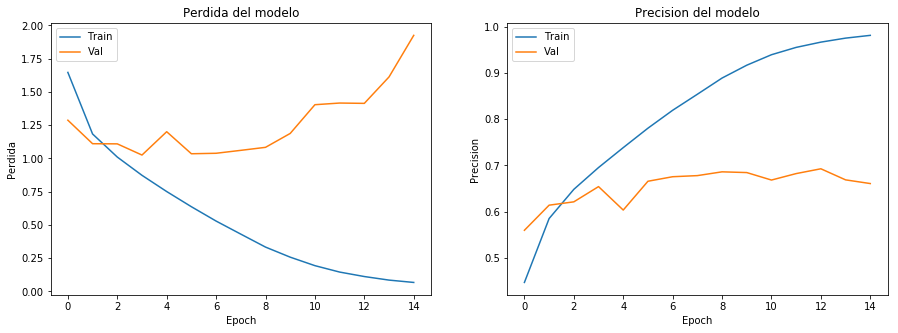

In [38]:
resumenGrafico(history)

Como apreciación inicial, el modelo resulta en overfitting muy fácilmente. Después de los 2 epochs el error de validación empieza aumentar y para los 15 ya se ha disparado, en contraste con el error de entrenamiento. Se prosigue con filtros de $4\times4$.

In [39]:
nc = 4 #convolutional filter size
model = Sequential()
model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [40]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [41]:
scores.append(model.evaluate(x_test,y_test,verbose=0))

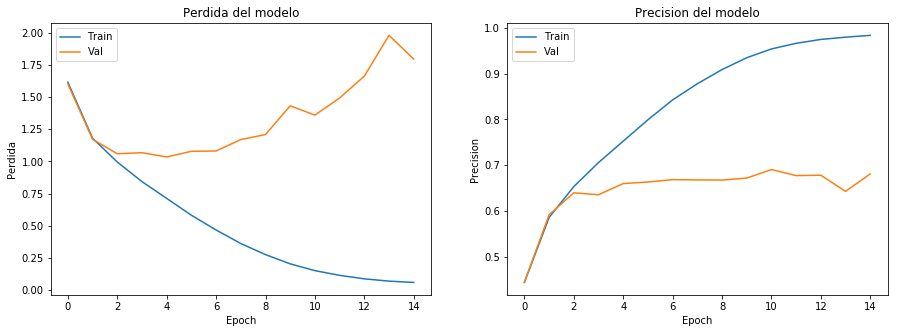

In [42]:
resumenGrafico(history)

Salvo el descenso al final, el modelo nuevamente sufre de overfitting tras 2 epochs.

In [67]:
nc = 5 #convolutional filter size
model = Sequential()
model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [68]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [45]:
scores.append(model.evaluate(x_test,y_test,verbose=0))

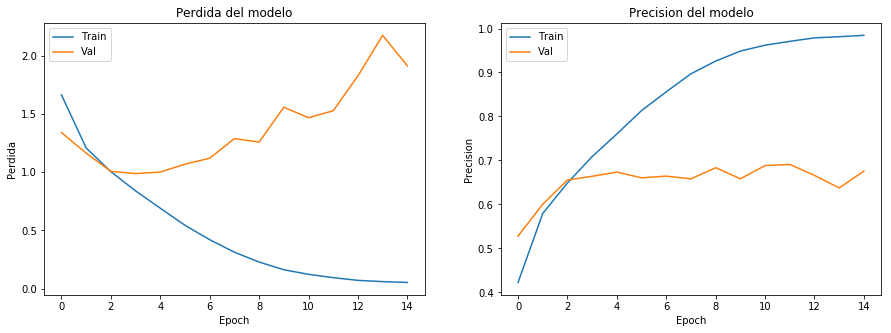

In [69]:
resumenGrafico(history)

Al igual que en el resto de los modelos, este empieza a tener overfitting rápidamente tras los 2 epochs.

A continuación se muestran los resultados finales de pérdida del modelo y precisión.

In [73]:
print("Test loss |","Test accuracy")
for i in range(0,3):
    print(scores[i])

Test loss | Test accuracy
[1.9543369068145753, 0.6409]
[1.828509199142456, 0.6655]
[2.0650175181388857, 0.656]


Los resultados parecen indicar que respecto al error, poca diferencia hace cambiar el tamaño del filtro, al igual que respecto a la precisión.

Se procede a repetir el procedimiento anterior utilizando una red profunda con 3 capas ocultas de 256 unidades.

In [48]:
nc = 3 #convolutional filter size
model = Sequential()
model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [49]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [50]:
scores.append(model.evaluate(x_test,y_test,verbose=0))

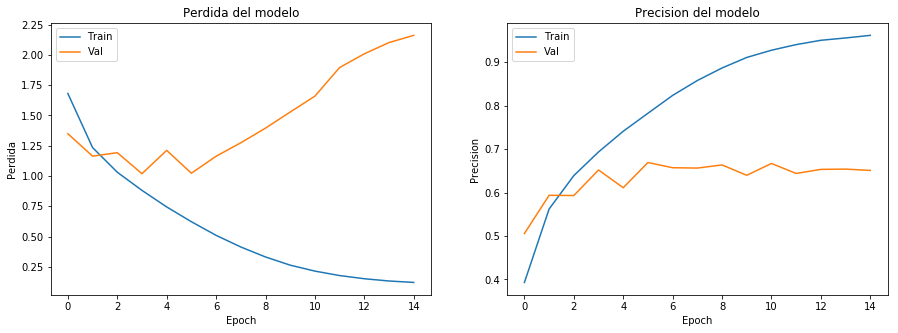

In [51]:
resumenGrafico(history)

El resultado parece ser similar a lo anterior visto, sin embargo el error final es mayor que en las redes shallow.

In [52]:
nc = 4 #convolutional filter size
model = Sequential()
model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [53]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [54]:
scores.append(model.evaluate(x_test,y_test,verbose=0))

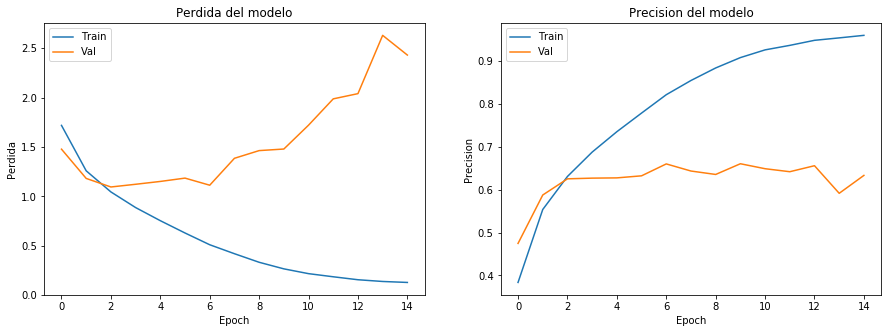

In [55]:
resumenGrafico(history)

Nuevamente aumenta el error anterior, acrecentando el overfitting.

In [58]:
nc = 5 #convolutional filter size
model = Sequential()
model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [59]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [60]:
scores.append(model.evaluate(x_test,y_test,verbose=0))

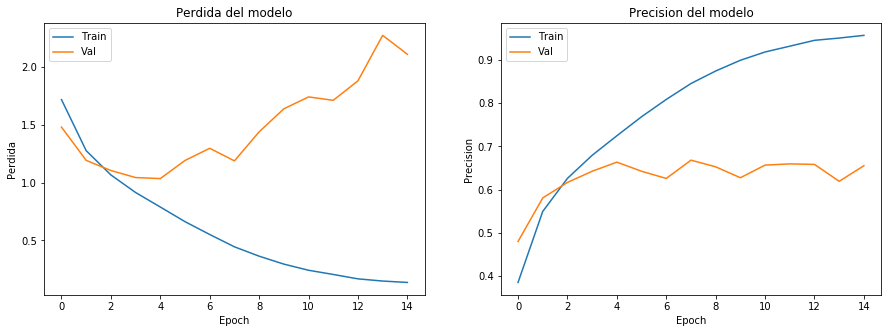

In [61]:
resumenGrafico(history)

Esta vez el error y la precisión se mantienen relativamente parecidas a la red con filtro de $3\times3$. Luego observamos las métricas finales.

In [74]:
print("Test loss |","Test accuracy")
for i in range(3,6):
    print(scores[i])

Test loss | Test accuracy
[2.2455313676834106, 0.6319]
[2.620751922798157, 0.6159]
[2.1388538093566893, 0.6389]


Los resultados parecen indicar que el tamaño de los filtros no tiene efecto significativo en el entrenamiento de un modelo, al menos se mantenga el stride constante. Sin embargo la arquitectura profunda tiene en promedio un overfitting mayor, presentando un error promedio mayor y precisión menor.

Parte g)

Se genera el modelo indicado, de arquitectura $C \times C \times P \times C \times C \times P \times F \times F$. Además se definen las variaciones del modelo que utilizan filtros más grandes y se agrega un normalizador dropout en la última capa escondida para mejorar el desempeño general.

In [81]:
historias=[]

In [82]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

In [83]:
epochs=25

In [84]:
opt = rmsprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [85]:
historias.append(history)

In [97]:
model = Sequential()
model.add(Conv2D(64, (4, 4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

In [98]:
epochs=25
batch_size=128

In [99]:
opt = rmsprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [100]:
historias.append(history)

In [101]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (4, 4), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

In [102]:
epochs=25

In [103]:
opt = rmsprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [104]:
historias.append(history)

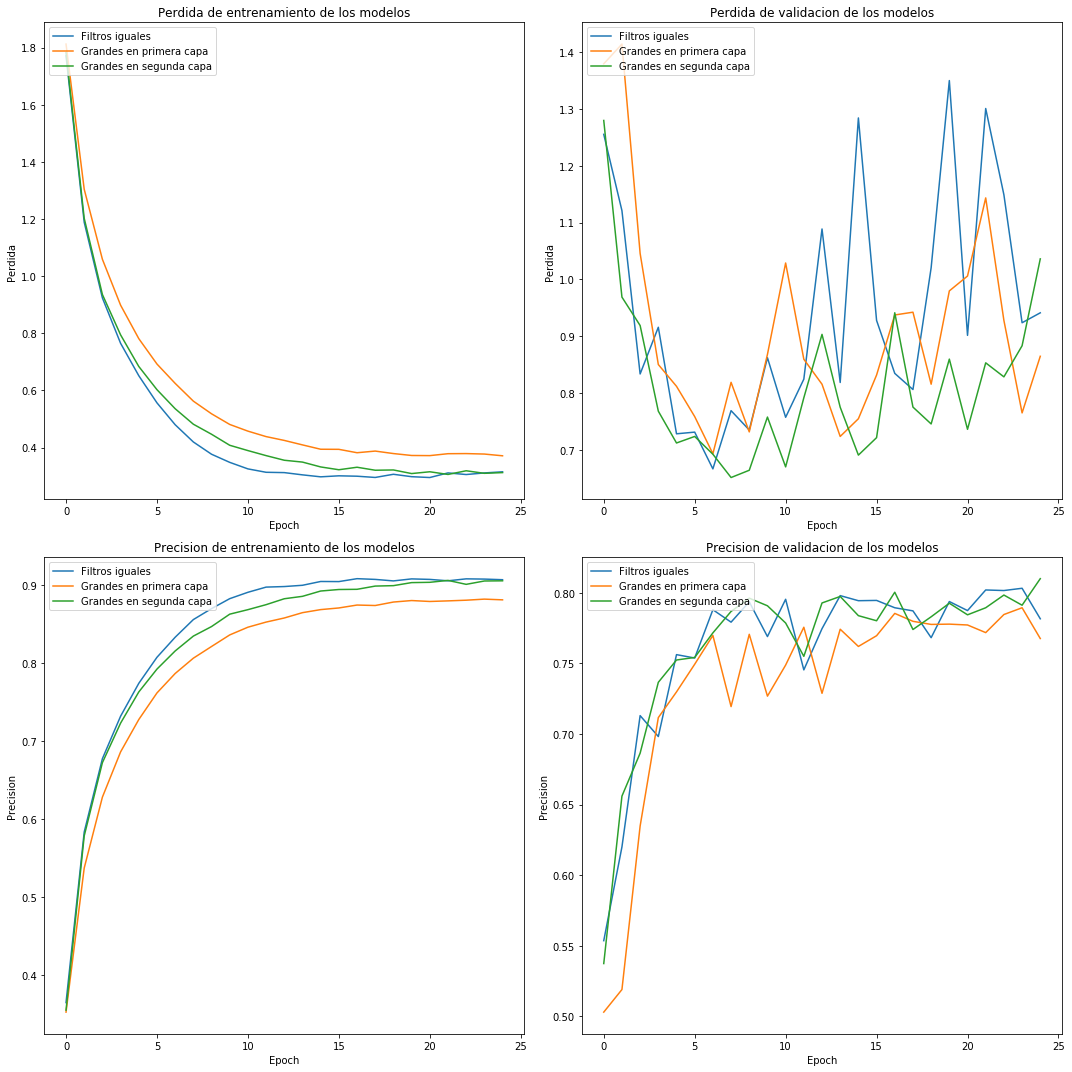

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
for i in range(3):
    ax[0].plot(historias[i].history['loss'])
    ax[1].plot(historias[i].history['val_loss'])
    ax[2].plot(historias[i].history['acc'])
    ax[3].plot(historias[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
plt.tight_layout()
plt.show()

Utilizando dropout se logró tener una precisión mayor al 75% en todos los modelos, independiente del tamaño de los filtros y orden de estos.

De los tres casos, ocupar los filtros más grandes en el primer par de capas convolucionales genera un peor desempeño de aprendizaje. Luego, hacer lo mismo en el segundo par de capas convolucionales significa una ligera pérdida de precisión respecto a mantener los filtros iguales, sin embargo también se puede apreciar de que los peaks experimentados en la pérdida de validación son menores que los del resto de los modelos.

Hasta ahora, mantener todas las capas con igual filtro se traduce en mejor aprendizaje, sin embargo también se producen cambios más violentos en la pérdida de validación.

In [112]:
historias2=[]

In [113]:
historias2.append(historias[0])

In [114]:
model = Sequential()
model.add(Conv2D(64, (4, 4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

In [115]:
opt = rmsprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [116]:
historias2.append(history)

In [117]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

In [118]:
opt = rmsprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

In [119]:
historias2.append(history)

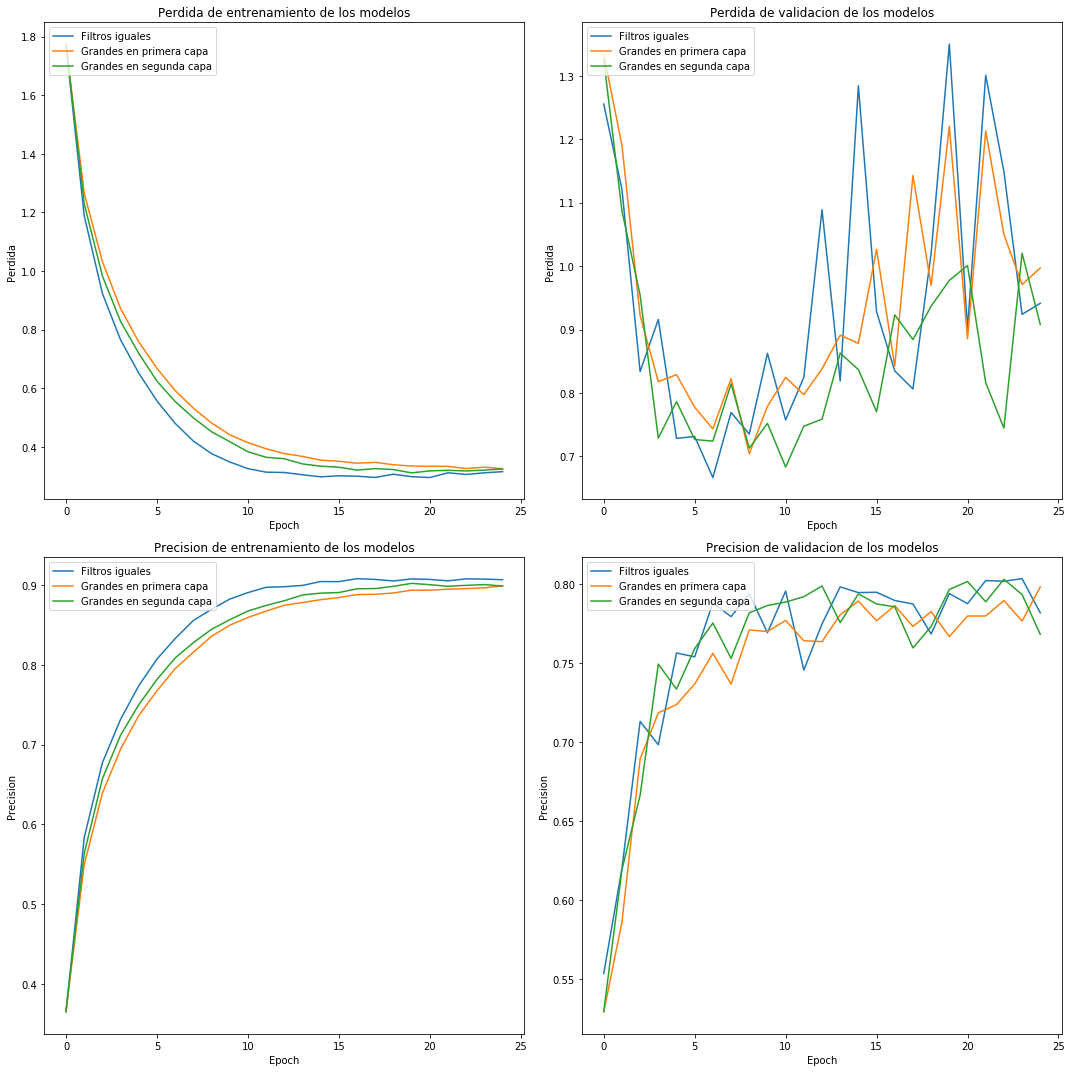

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
for i in range(3):
    ax[0].plot(historias2[i].history['loss'])
    ax[1].plot(historias2[i].history['val_loss'])
    ax[2].plot(historias2[i].history['acc'])
    ax[3].plot(historias2[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(['Filtros iguales', 'Grandes en primera capa','Grandes en segunda capa'], loc='upper left')
plt.tight_layout()
plt.show()

Si solo utilizamos un filtro más grande en la primera capa o en la segunda, se repiten los resultados anteriores, con una pérdida menor de precisión por parte del modelo con filtro grande en la primera capa. Por otro lado, utilizar un filtro mayor en la segunda (en contraste con el análisis anteriores) da un resultado similar.

Finalmente, todos los modelos tienden a tener comportamientos similares respecto al overfitting, salvo el modelo con filtros grandes en la segunda capa convolucional, que en ambas variaciones muestra tener peaks menos pronunciados.

De esto se puede concluir que la utilización de filtros grandes en capas internas podría ayudar a prevenir el overfitting, al costo de un aprendizaje más lento.

Parte h)

Las capas de pooling son reemplazadas por convoluciones con stride 2.

In [118]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_117 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_118 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 16, 16, 64)        36928     
__________

La utilización de strides para hacer saltos tiene como consecuencia que la dimensionalidad de la entrada disminuya con cada convolución con stride 2, teniendo el mismo efecto que usando pooling.

Sin embargo, a diferencia de pooling, utilizar convoluciones implica agregar unidades a la red.

Se procede a entrenar el modelo.

In [121]:
epochs=25

In [122]:
opt = rmsprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)

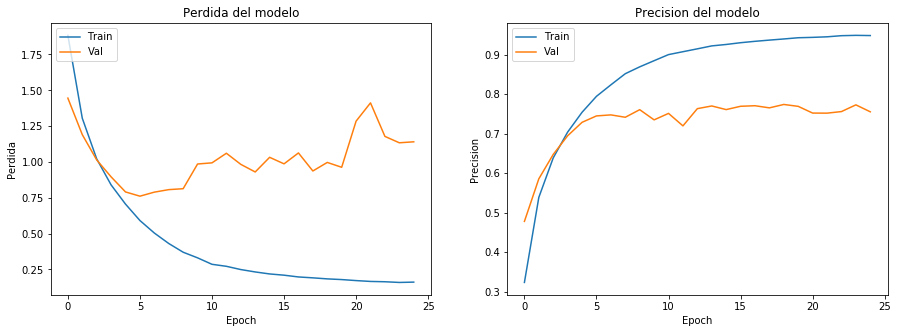

In [124]:
resumenGrafico(history)

En base al gráfico, el comportamiento casi idéntico de este modelo corrobora la propuesta del enunciado: pooling puede ser reemplazado por convoluciones con stride pues el stride disminuye la dimensionalidad de los datos, pero vale notar que el número de parámetros entrenables aumenta por la naturaleza de la convolución.

Por lo anterior, se pueden esperar tiempos aumentados en el entrenamiento.

Adicionalmente, el modelo que usaba pooling sufrió de overfitting 1 epoch después y poseía una precisión ligeramente mayor en el conjunto de validación tras finalizar todos los epochs, por lo que bajo estas condiciones se recomienda utilizar pooling en lugar de convoluciones con strides.

Parte i)

Se guardan los conjuntos de testeo en una variable auxiliar.

In [18]:
x_t=x_test
y_t=y_test

Luego se toman los último 5,000 valores para utilizar como datos de validación.

In [199]:
x_test=np.delete(x_train,np.s_[0:45000],axis=0)
y_test=np.delete(y_train,np.s_[0:45000],axis=0)

Y se eliminan estos valores del conjunto de entrenamiento.

In [200]:
x_train2=np.delete(x_train,np.s_[45000:50000],axis=0)
y_train2=np.delete(y_train,np.s_[45000:50000],axis=0)

El modelo utilizado en el ítem e) será entrenado con la aumentación de los datos.

In [201]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
opt = rmsprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

Para mantener el tiempo al mínimo, se harán solamente 15 epochs.

In [202]:
epochs=15

In [203]:
from keras.preprocessing.image import ImageDataGenerator

In [204]:
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train2)
history1=model.fit_generator(datagen.flow(x_train2, y_train2,batch_size=batch_size),steps_per_epoch=x_train2.shape[0], epochs=epochs,validation_data=(x_test, y_test))

Epoch 1/15
45000/45000 [==============================] - 1631s 36ms/step - loss: 0.4328 - acc: 0.8547 - val_loss: 1.1706 - val_acc: 0.7636
Epoch 2/15
45000/45000 [==============================] - 1630s 36ms/step - loss: 0.2974 - acc: 0.9085 - val_loss: 1.2211 - val_acc: 0.8040
Epoch 3/15
45000/45000 [==============================] - 1627s 36ms/step - loss: 0.2895 - acc: 0.9158 - val_loss: 1.7217 - val_acc: 0.7836
Epoch 4/15
45000/45000 [==============================] - 1627s 36ms/step - loss: 0.2803 - acc: 0.9218 - val_loss: 1.4447 - val_acc: 0.7836
Epoch 5/15
45000/45000 [==============================] - 1628s 36ms/step - loss: 0.2688 - acc: 0.9276 - val_loss: 1.3683 - val_acc: 0.7708
Epoch 6/15
45000/45000 [==============================] - 1629s 36ms/step - loss: 0.2640 - acc: 0.9307 - val_loss: 1.5598 - val_acc: 0.7944
Epoch 7/15
45000/45000 [==============================] - 1629s 36ms/step - loss: 0.2539 - acc: 0.9350 - val_loss: 1.6815 - val_acc: 0.7926
Epoch 8/15
45000/450

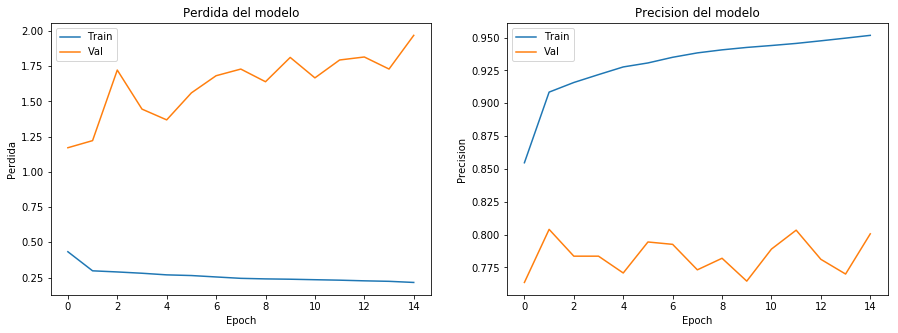

In [205]:
resumenGrafico(history1)

El aprendizaje de este modelo en base al conjunto de entrenamiento fue mucho más rápido que otro modelos, pero también se puede observar muy claramente de que también se produce overfitting antes que en otros modelos y en mayor magnitud.

Una posible explicación al por qué del overfitting es debido a la velocidad de aprendizaje durante el entrenamiento, por lo que una solución podría ser disminuir la tasa de aprendizaje del modelo.

La aumentación de datos es considerado un método de normalización pues entrega mayor información al modelo al utilizar variaciones de una imagen sin cambiar la clase de esta (después de todo, un gato rotado sigue siendo un gato).

Otra manera de explicar por qué aporta información es la la naturaleza de los cambios, si bien se hacen cambios sobre la imagen completa, los patrones que las capas convolucionales captan siguen presentes y por ello aún son identificables.

Parte j)

Se define el modelo con mejor desempeño, es decir el construido en la pregunta g) con regularización después de la última capa escondida.

In [20]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

Se entrena el modelo con 25 epochs.

In [21]:
epochs=25

In [22]:
batch_size=128

In [23]:
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.1,shuffle=True,verbose=0)
score = model.evaluate(x_test, y_test, verbose=0)

Hacemos las predicciones en base al conjunto de pruebas.

In [27]:
y_p=model.predict(x_t)

Dado que las predicciones son probabilidades, sencillamente tomamos la probabilidad mayor para cada una de las predicciones hechas y luego calculamos la matriz de confusión.

In [28]:
from sklearn.metrics import confusion_matrix
y_t2=[np.argmax(t) for t in y_t]
y_p2=[np.argmax(t) for t in y_p]
conf_mat=confusion_matrix(y_t2,y_p2)

Por último, buscamos el mayor valor no correspondiente a la diagonal para encontrar el par más confundido.

In [29]:
max_val=0
ind1=0
ind2=0
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        if(i==j):
            continue
        if(conf_mat[i][j]+conf_mat[j][i]>max_val):
            max_val=conf_mat[i][j]+conf_mat[j][i]
            ind1=i
            ind2=j
print(ind1,ind2)
print(label_names[ind1],label_names[ind2])

3 5
cat dog


Por lo tanto, según la matriz de confusión el par más confundido es perros y gatos. Esto es entendible pues ambos son mamíferos con características muy similares, por no decir que las diferencias existentes pueden hacerse menos evidentes debido a la baja resolución de las imágenes.

In [233]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Observando la lista de nombres, intuitivamente podemos decir además de que son el par cuyas fotos son más probable de que sean parecidas. La razón por la que el modelo los confunde es por la naturaleza del análisis, es decir, observa facciones individuales y luego en base a ellas toma su decisión. Como ya se estableció, muchas de estas facciones son parecidas tanto por como son los animales como por la resolución de la imagen.

Parte k)

Se utilizará la red entrenada en el punto anterior. Primero se guardan las capas pedidas, la primera y última capa convolucional.

In [139]:
conv1=model.layers[0]
conv2=model.layers[8]

Para mejor visualización, se analizará uno de los feature maps utilizados.

In [137]:
conv1.get_weights()[0].transpose()[0].transpose()

array([[[-0.04766031, -0.04929885,  0.08132248],
        [ 0.04451025, -0.0826097 ,  0.05440309],
        [-0.04464233, -0.05407467,  0.01531563]],

       [[-0.07397301, -0.07116622,  0.01650781],
        [ 0.09870806, -0.04346245, -0.00104858],
        [ 0.01441362, -0.04896982, -0.01514244]],

       [[-0.09692304, -0.00241122, -0.01438539],
        [-0.01323069, -0.06911708, -0.06310741],
        [ 0.05399697, -0.02031115,  0.01575025]]], dtype=float32)

El arreglo anterior representa los pesos de la entrada de $3\times3$ con 3 canales hacie uno de los feature maps. 

In [140]:
conv2.get_weights()

[array([[[[-9.16430652e-02, -1.81155838e-02,  2.28956807e-02, ...,
           -1.50248669e-02, -3.41422260e-02,  5.59787415e-02],
          [ 2.23223884e-02, -5.57200909e-02,  8.98329243e-02, ...,
           -3.07279769e-02, -1.45957366e-01, -4.21114042e-02],
          [-1.15248479e-01,  1.96899012e-01, -5.83017133e-02, ...,
           -5.28939776e-02, -8.83483440e-02,  6.47619069e-02],
          ...,
          [-2.18934551e-01,  5.65627292e-02,  1.43005680e-02, ...,
           -7.01808780e-02,  1.15687065e-01,  3.54540497e-02],
          [-4.73879538e-02,  1.24265097e-01, -8.92246813e-02, ...,
           -5.57225011e-02,  3.73172835e-02,  3.13823640e-01],
          [-6.67087510e-02, -6.97401464e-02,  6.88536689e-02, ...,
           -2.42258057e-01,  1.11376941e-01,  3.12579200e-02]],
 
         [[ 1.11404613e-01, -7.68150538e-02, -1.43299000e-02, ...,
            1.81163475e-02, -5.59689589e-02,  1.38837829e-01],
          [ 6.09097853e-02,  6.76885620e-02,  7.32694194e-03, ...,
     

Comparando, los pesos de la última capa convolucional son bastante más numerosos debido la cantidad de unidades generadas en capas previas.

Utilizando _backend_, se evalúan 4 imágenes y los resultados en cada capa son guardados en *layer_outs*.

In [33]:
from keras import backend as K

inp = model.input                                           
outputs = [layer.output for layer in model.layers]         
functor = K.function([inp]+ [K.learning_phase()], outputs ) 

# Testing
layer_outs = functor([x_t[0:4], 1.])

Luego graficamos los outputs.

In [42]:
from matplotlib.pyplot import imshow

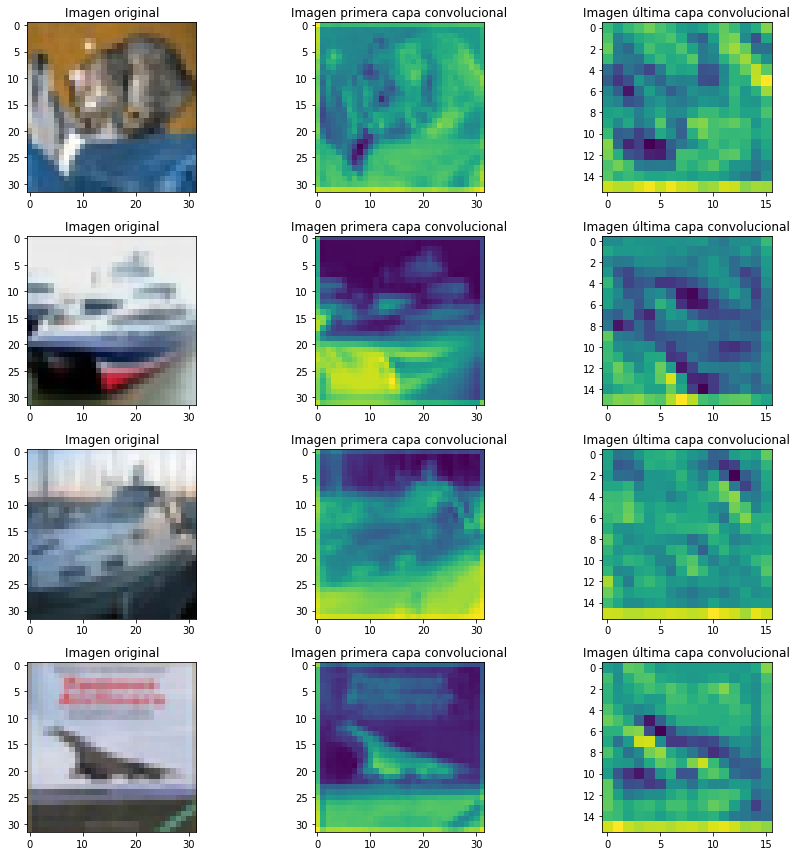

In [142]:
fig=plt.figure(figsize=(12,12))
rows=4
columns=3
j=0
for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    if(i%3==1):
        plt.title('Imagen original')
        plt.imshow(x_t[j])
    elif(i%3==2):
        plt.title('Imagen primera capa convolucional')
        plt.imshow(layer_outs[0][j].transpose()[0].transpose())
    elif(i%3==0):
        plt.title('Imagen última capa convolucional')
        plt.imshow(layer_outs[8][j].transpose()[0].transpose())
        j+=1
plt.tight_layout()
plt.show()

De este conjunto de imágenes, la observación más evidente es que en las primera capa convolucional se identifican patrones más generales, mientras que en la última capa apenas es reconocible la imagen, pues en capas más profundas se estudian patrones más complejos y abstractos.

Parte de este comportamiento se debe a como funciona el pooling, disminuyendo la entrada de $32\times32$ a una de $16\times16$.

Adicionalmente, es posible visualizar en los gráficos de la última capa convolucional que ciertos detalles parcialmente observables en la primera capa son intensificados con colores más extremos como amarillo brillante o azul oscuro. Estos pueden ser interpretados como los patrones buscados por esta última capa.